In [1]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
np.set_printoptions(precision=2)

In [3]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import get_variance, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict

In [4]:
# aggregate both visual embeddings and language embeddings
def aggregate_embeddings_visual_and_language(input_struct,n_sample_per_visual,n_sample_per_language):
	words=input_struct['words']
	embed_dict=dict()
	for word in words:
		n_sample_v = min(len(input_struct['embeds'][word]['visual']), n_sample_per_visual)
		visual_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['visual'],n_sample_v)),axis=0)
		n_sample_l = min(len(input_struct['embeds'][word]['language']), n_sample_per_language)
		language_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['language'],n_sample_l)),axis=0)
		#embed_dict[word]=dict(visual=np.expand_dims(visual_temp,axis=0),language=language_temp)
		embed_dict[word]=dict(visual=visual_temp,language=np.squeeze(language_temp))
	return dict(embeds=embed_dict,words=words)

In [5]:
def get_alignment_strength(struct,concepts,relative):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    if relative:
        return permutation(z_0,z_1,n_sim=100)[0]
    else:
        return compute_alignment_strength(z_0,z_1)

In [6]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_ll_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_ll_swav_bert_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [34]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [8]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [9]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [10]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [11]:
def compute_alignment(concepts,shuffled_concepts,struct,relative):
    num_list=list()
    for sh_concepts in shuffled_concepts:
        num_list.append(get_alignment_strength(struct,sh_concepts,relative))
    temp=mean_confidence_interval(num_list)
    return get_alignment_strength(struct,concepts,relative),temp[0],temp[1]

In [12]:
def compute_alignment_sns(concepts,shuffled_concepts,struct,relative):
    num_list=list()
    for sh_concepts in shuffled_concepts:
        num_list.append(get_alignment_strength(struct,sh_concepts,relative))
    return get_alignment_strength(struct,concepts,relative),num_list

In [13]:
def sim_in_order(struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    
    xs=list()
    ag_true=list()
    ag_sh=list()
    ag_sh_err=list()

    for idx in range(0,len(concepts),step):
        if concept_accum:
            concept_group=concepts[:idx+step]
        else:
            concept_group=concepts[idx:idx+step]
        
        shuffled_list=list()
        temp=concepts.copy()
        for i in range(num_simulation):
            random.shuffle(temp)
            temp2=temp[:len(concept_group)]
            shuffled_list.append(temp2)
            # print(sorted(temp2))
            # for j in temp2:
            #     if j not in concept_group:
            #         print(j)
        
        xs.append(min(idx+step,len(concepts)))
        ag_rts=compute_alignment(concept_group,shuffled_list,struct,relative)
        ag_true.append(ag_rts[0])
        ag_sh.append(ag_rts[1])
        ag_sh_err.append(ag_rts[2])
    
    return ag_true,ag_sh,ag_sh_err,xs

In [14]:
def sim_in_order_sns(struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    
    ag_true=list()
    ag_sh=list()

    for idx in range(0,len(concepts),step):
        if concept_accum:
            concept_group=concepts[:idx+step]
        else:
            concept_group=concepts[idx:idx+step]
        
        shuffled_list=list()
        temp=concepts.copy()
        for i in range(num_simulation):
            random.shuffle(temp)
            temp2=temp[:len(concept_group)]
            shuffled_list.append(temp2)
        
        x=min(idx+step,len(concepts))
        ag_rt=compute_alignment_sns(concept_group,shuffled_list,struct,relative)
        ag_true.append((x,ag_rt[0]))
        for item in ag_rt[1]:
            ag_sh.append((x,item))
    
    return ag_true,ag_sh

In [28]:
def plot_percentage_in_order(title,struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    t1=time.time()
    ag_true,ag_sh,ag_sh_err,xs=sim_in_order(struct,concepts,step,num_simulation,concept_accum,relative)
    t2=time.time()
    print(t2-t1)
    
    plt.plot(xs,ag_true,color="green",label="Alignment Strength in AoA Order")
    #plt.plot(xs,ag_sh,color="red",label="Alignment Strength of Random Concepts")
    plt.errorbar(xs,ag_sh,yerr =ag_sh_err,color="red",label="Alignment Strength of Random Concepts")
    plt.title(title)
    plt.xlabel("Number of Concepts in the System")
    plt.ylabel("Alignment Strength")
    plt.legend()
    
    plt.savefig("../figs/temp.png")
    
    print(xs)
    print("alignment true:",ag_true)
    print("alignment shuffled:",ag_sh)

In [29]:
def plot_percentage_in_order_sns(title,struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    t1=time.time()
    ag_true,ag_sh=sim_in_order_sns(struct,concepts,step,num_simulation,concept_accum,relative)
    t2=time.time()
    print(t2-t1)
    
    df1 = pd.DataFrame(np.array(ag_true), columns = ['x', 'y'])
    df1['type']="true order"
    # df1['z']=1
    # df1['z'][0]=2
    df2 = pd.DataFrame(np.array(ag_sh), columns = ['x', 'y'])
    df2['type']="shuffled"
    
    df=pd.concat([df1,df2])
    
    print(df.index.duplicated())
    
    # sns.set_style('darkgrid')  # darkgrid, white grid, dark, white and ticks
    plt.rc('axes', titlesize=18)  # fontsize of the axes title
    plt.rc('axes', labelsize=14)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=13)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=13)  # fontsize of the tick labels
    plt.rc('legend', fontsize=13)  # legend fontsize
    plt.rc('font', size=13)  # controls default text sizes
    plt.figure(figsize=(10, 6), tight_layout=True)
    
    fig, ax = plt.subplots()
    # sns.lineplot(x="z",y="y",data=df1.iloc[:3])
    sns.lineplot(x="x",y="y",data=df,hue="type")
    #sns.lineplot(x="x",y="y",data=df1,hue="type",palette=[sns.color_palette("Paired")[7],sns.color_palette("Paired")[3]])
    # sns.pointplot(x="z",y="y",data=df1.iloc[:3])
    #sns.pointplot(x="x",y="y",data=df,hue="type",palette=[sns.color_palette("Paired")[7],sns.color_palette("Paired")[3]])
    sns.despine()
    
    # ax.legend(loc=4)
    # ax.set_xlim(0,10)
    # ax.set_xticks(range(0,len(concepts),step))
    # ax.set_xticklabels(range(0,len(concepts),step))
    # ax.set_ylim(0, 1)
    # ax.set_yticks([0.2,0.4,0.6])

    ax.set(xlabel='Number of Exemplars Aggregated', ylabel='Relative Alignment Strength')
    plt.tight_layout()
    plt.savefig("../figs/mit_visual_agg.png")
    plt.show()

In [32]:
list(list(zip(*noun_aoa_sorted))[0])

['water',
 'bed',
 'apple',
 'sky',
 'finger',
 'head',
 'cup',
 'man',
 'toilet',
 'chair',
 'door',
 'hand',
 'cow',
 'dog',
 'cat',
 'ear',
 'food',
 'foot',
 'window',
 'flower',
 'leg',
 'eye',
 'shoe',
 'baby',
 'word',
 'wheel',
 'animal',
 'box',
 'arm',
 'tree',
 'face',
 'nose',
 'bus',
 'girl',
 'banana',
 'sheep',
 'hat',
 'sock',
 'pillow',
 'car',
 'ball',
 'lady',
 'mouth',
 'snow',
 'woman',
 'book',
 'hair',
 'grass',
 'house',
 'fork',
 'bathroom',
 'bowl',
 'cloud',
 'bird',
 'leaf',
 'bottle',
 'bread',
 'tail',
 'cheese',
 'line',
 'airplane',
 'boat',
 'picture',
 'horse',
 'elephant',
 'rock',
 'basket',
 'people',
 'seat',
 'bear',
 'park',
 'button',
 'towel',
 'television',
 'paper',
 'sandwich',
 'truck',
 'street',
 'bag',
 'mirror',
 'road',
 'sink',
 'person',
 'bicycle',
 'wall',
 'carrot',
 'jacket',
 'wrist',
 'giraffe',
 'clock',
 'coat',
 'umbrella',
 'hill',
 'child',
 'lamp',
 'air',
 'neck',
 'beach',
 'shirt',
 'boot',
 'dress',
 'wave',
 'glass',

88.88778710365295
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 207]
alignment true: [-0.07878787878787878, 0.09591567852437417, 0.14964752228903172, 0.1304229159285649, 0.2096454405048945, 0.29092088632046387, 0.32696868863469736, 0.274868124878069, 0.2620991565261481, 0.213674406489634, 0.2534110941902355, 0.2758714728705036, 0.26493786002858594, 0.2491066711787752, 0.2670746506206825, 0.26667583561771024, 0.25837759155364015, 0.26916609107969497, 0.2630025972077996, 0.2581982472056939, 0.24907886170883778, 0.24608046423574206, 0.2578843942199301, 0.278972098312932, 0.2732407129046878, 0.28606231369079177, 0.2844515325482144, 0.2944980195145891, 0.2621121592621184, 0.25632585430904475, 0.24561955792686282, 0.24122929203400348, 0.21876635586361093, 0.21533340560394737, 0.20689240961462138, 0.2017817140644275, 0.20622194862251872, 0.196575584211799

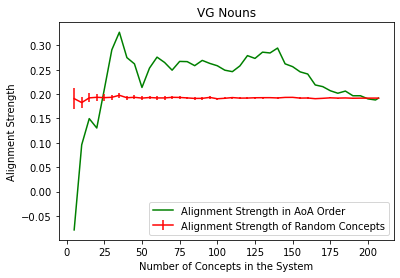

In [35]:
# bert language embeddings last layer
plot_percentage_in_order("VG Nouns",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=5,num_simulation=1000,concept_accum=True,relative=False)

24.554658889770508
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 128]
alignment true: [0.5636363636363636, 0.22160737812911724, 0.09770889487870618, 0.21030149544891902, 0.207143634929277, 0.22143039375336218, 0.2529804844451509, 0.2964743911099839, 0.25876962274713927, 0.26192263528576193, 0.2450901252038914, 0.26298099132648795, 0.2363291108485726, 0.2189194779796477, 0.21424776190829437, 0.1841059120807063, 0.19736754342961402, 0.19316508736413934, 0.19874857711085714, 0.19684661105027593, 0.2054695092026423, 0.22618948149281304, 0.21330782629207282, 0.20545807979510272, 0.19435148594079343, 0.19018558024276752]
alignment shuffled: [0.16818181818181815, 0.19017103331048169, 0.18595284201434736, 0.18111027685397865, 0.1866480685322118, 0.19379515024305402, 0.18874448399802068, 0.18909276733169594, 0.1893329309027571, 0.1882940905471677, 0.1888739282741651, 0.18769900127061281, 0.1894128064549797, 0.18835809065994, 0.19123078

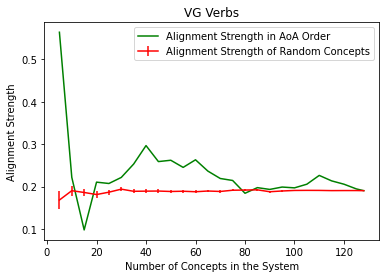

In [31]:
# bert language embeddings last layer
plot_percentage_in_order("VG Verbs",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=5,num_simulation=1000,concept_accum=True,relative=False)

232.40431904792786
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 162]
alignment true: [0.78, 0.86, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.8017, 0.9308999999999998, 0.9599000000000001, 0.9861999999999999, 0.9928, 0.9959, 0.9988999999999999, 0.9998, 0.9997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


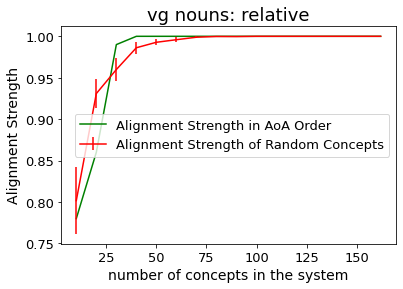

In [142]:
# bert language embeddings last layer
plot_percentage_in_order("vg nouns: relative",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

489.63731813430786
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.06, 0.66, 0.95, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.6658999999999999, 0.7281000000000002, 0.8504, 0.8619, 0.9094, 0.9242, 0.9451000000000004, 0.9558, 0.9816000000000001, 0.9857, 0.9872000000000001, 0.9904999999999999, 0.9952000000000001, 0.9958, 0.9984999999999999, 0.9986, 0.9991000000000001, 0.9998, 0.9997, 0.9998, 1.0]


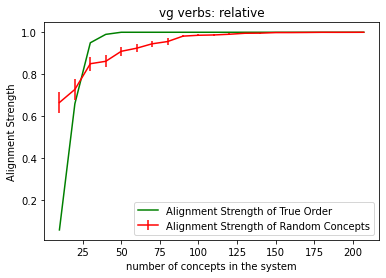

In [21]:
# bert language embeddings last layer
plot_percentage_in_order("vg verbs: relative",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

In [56]:
#Plot

0.3051159381866455
[False False False False False False False False False False False False
 False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False F

ValueError: cannot reindex from a duplicate axis

<Figure size 720x432 with 0 Axes>

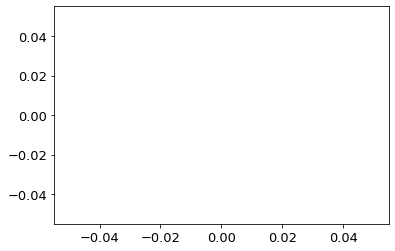

In [207]:
# bert language embeddings last layer
plot_percentage_in_order_sns("vg nouns: absolute",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=10,concept_accum=True,relative=False)

In [ ]:
ag_true,ag_sh,ag_sh_err,xs=sim_in_order(aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=5,num_simulation=1000,concept_accum=True,relative=False)